In [ ]:
%% 

In [1]:

%matplotlib inline
from vadoseZone import LaioVadoseZone, PorporatoVadoseZone
from groundwaterZone import GroundwaterZone, LinearReservoir
from REW import REW
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

/Users/nathankarst/anaconda/envs/py2k_gis/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [9]:
def generateSyntheticRainfall(numIntervals=365*24,L=10/30/24,alpha=20):
    ''' Set up to generate 1 year of rainfall hourly rainfall data with 10 events per month
        and an average depth of 20mm 
    '''
    return np.array([np.random.exponential(alpha) if np.random.uniform() > np.exp(-L) else 0.0 for i in range(numIntervals)])

In [13]:
def waterBudget(vz=LaioVadoseZone,gz=LinearReservoir): 
    ## time domain
    Tmax    = 365*5.               # days (or whatever)
    dt      = 1/24.               
    t       = np.linspace(0,Tmax,np.ceil(Tmax/dt))

    ## rainfall statistics
    alpha       = 2.5               # (cm / event)^{-1}
    L           = 10/30.            # events / day

    rainfall = generateSyntheticRainfall(len(t),L*dt,alpha)/dt 

    rew = REW(vz,gz,**{'ppt':rainfall})

    ## init. 
    vadozeStorage   = np.zeros(np.size(t))
    groundwater     = np.zeros(np.size(t))
    discharge       = np.zeros(np.size(t))
    leakage         = np.zeros(np.size(t))
    et              = np.zeros(np.size(t))
    overlandFlow    = np.zeros(np.size(t))
    intercepted     = np.zeros(np.size(t))

    for i in range(len(rainfall)):
        vzFluxes = rew.vz.update(dt,**{'ppt':rew.ppt[i]})
        vadozeStorage[i]    = rew.vz.storage                # [cm]
        leakage[i]          = vzFluxes.get('leakage',0)*dt             # [cm]
        et[i]               = vzFluxes.get('ET',0)*dt                  # [cm]
        intercepted[i]      = vzFluxes.get('interceptedRainfall',0)*dt # [cm]
        overlandFlow[i]     = vzFluxes.get('overlandFlow',0)*dt        # [cm]
        
        gzFluxes = rew.gz.update(dt,**{'leakage':rew.vz.leakage}) 
        groundwater[i]  = rew.gz.groundwater                # [cm]
        discharge[i]    = gzFluxes.get('discharge',0)*dt    # [cm]


    YtdWater       = np.cumsum(rew.ppt)*dt                  # [cm]
    YtdET          = np.cumsum(et)                          # [cm]
    YtdDischarge   = np.cumsum(discharge)                   # [cm]
    YtdOverland    = np.cumsum(overlandFlow)                # [cm]
    YtdIntercepted = np.cumsum(intercepted)                 # [cm]
    

    plt.plot(t,vadozeStorage/YtdWater,label='Vadoze Storage')
    plt.plot(t,groundwater/YtdWater,label='Groundwater Storage')    
    plt.plot(t,YtdET/YtdWater,label='Cumulative ET Volume')
    plt.plot(t,YtdIntercepted/YtdWater,label='Cumulative Intercepted Rainfall Volume')
    plt.plot(t,YtdDischarge/YtdWater,label='Cumulative Discharge Volume')
#     plt.plot(t,YtdOverland/YtdWater,label='Cumulative Overland Flow Volume')
    plt.plot(t,(vadozeStorage+YtdET+groundwater+YtdIntercepted+YtdDischarge+YtdOverland)/YtdWater,label='Total Volume')
    plt.ylabel('Portion of Water Balance []')
    plt.xlabel('Time [d]')
    plt.legend()
    plt.ylim(0,1.25)
    plt.show()

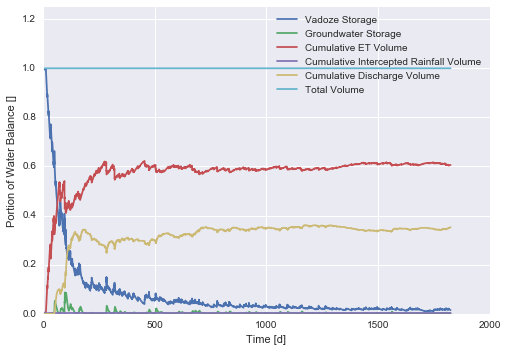

In [14]:
waterBudget()